In [1]:
from math import ceil
from spatial_scan import scan, deploy, rand_deploy
from vae2d import VAE, encoder, decoder, tf, keras
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib notebook

2023-06-06 17:59:45.568164: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-06 17:59:50.168431: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-06-06 17:59:50.168738: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-06-06 17:59:50.168771: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
nepochs = 5
half=True

In [3]:
batch_len = 1000
lmax=0.5
half=False

xyz = []
labels = []
with open("../list.txt") as lst:
    for l in lst.readlines():
        a=l.split(" ")
        with open("../"+a[1].strip()) as f:
            data = [[float(i.strip()) for i in s.split(" ") if i!=""] for s in f.read().split("\n") if s!=""]
            xyz.extend([[[data[h][i+2*j]for i in range(2)]for j in range(len(data[h])//2)]for h in range(len(data))])
            #print(len(data[0]), len(xyz[0]), len(xyz[0][0]))
            labels.extend([a[0] for h in range(len(data))])
            del data

            
permutation = np.random.permutation(len(xyz))

xyx = np.array(xyz)[permutation]
labels = np.array(labels)[permutation]

# print(len(data), [len(data[i]) for i in range(len(data))])
model_checkpoint_callback = keras.callbacks.ModelCheckpoint("./checkpoints2d/", save_best_only=True)
# currently unused
    

In [4]:
if True:#len(argv)>2 and argv[2]=="--resume":
    encoder=keras.models.load_model("./aug-model-info2d/enc")
    decoder=keras.models.load_model("./aug-model-info2d/dec")

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

losses=[]
rec_losses=[]
kl_losses=[]
l_values=[]

In [5]:
class CustomCallback(keras.callbacks.Callback):

    def __init__(self, mymodel):
        super().__init__()
        self.mymodel=mymodel
        
    def on_epoch_begin(self, epoch, logs):
        global lmax, half
        self.mymodel.l.assign( (1-1/(1+epoch/10))*lmax )
        lmax+=0.0005
        if not half:
            self.mymodel.r.assign( 1/(1+epoch/10) )
        else:
            self.mymodel.r.assign( 0 )
        
        if not (epoch % 10):
            print(epoch, end="\t", flush=True)

regularization_callback = CustomCallback(vae)

old="""            
def change_l(e,log):
    global lmax, half
    vae.l = (1-1/(1+e/10))*lmax
    lmax+=0.0005
    if not half:
        vae.r = 1/(1+e/10)
    else:
        vae.r = 0
    #print("l: ", vae.l)

regularization_callback = keras.callbacks.LambdaCallback(on_epoch_begin=change_l)
"""



In [6]:
#encoder.summary()

In [7]:
#decoder.summary()

In [8]:
for i in range(ceil(len(xyz)/batch_len)):
    bdata = [] # will hold bucketed data version
    for j in range(batch_len*i, batch_len*(i+1)):
        if j>len(xyz):
            break
        #print(xyz[j])
        bdata.append([scan(xyz[j],8,8, dim=2)])
    dataset = tf.data.Dataset.from_tensor_slices((bdata,))
    print("\n ----- i: ",i)
    if i>ceil(len(xyz)/batch_len)//2:
        half=True
    
    vae.fit(dataset, epochs=nepochs, batch_size=128, callbacks=[regularization_callback], verbose=0)
    losses.extend(vae.history.history["loss"])
    rec_losses.extend(vae.history.history["reconstruction_loss"])
    kl_losses.extend(vae.history.history["kl_loss"])
    l_values.extend(vae.history.history["l"])


 ----- i:  0
0	
 ----- i:  1
0	
 ----- i:  2
0	
 ----- i:  3
0	
 ----- i:  4
0	
 ----- i:  5
0	
 ----- i:  6
0	
 ----- i:  7
0	
 ----- i:  8
0	
 ----- i:  9
0	
 ----- i:  10
0	
 ----- i:  11
0	
 ----- i:  12
0	
 ----- i:  13
0	
 ----- i:  14
0	
 ----- i:  15
0	
 ----- i:  16
0	
 ----- i:  17
0	
 ----- i:  18
0	
 ----- i:  19
0	
 ----- i:  20
0	
 ----- i:  21
0	
 ----- i:  22
0	
 ----- i:  23
0	
 ----- i:  24
0	
 ----- i:  25
0	
 ----- i:  26
0	
 ----- i:  27
0	
 ----- i:  28
0	
 ----- i:  29
0	
 ----- i:  30
0	
 ----- i:  31
0	
 ----- i:  32
0	
 ----- i:  33
0	
 ----- i:  34
0	
 ----- i:  35
0	
 ----- i:  36
0	
 ----- i:  37
0	
 ----- i:  38
0	
 ----- i:  39
0	

In [9]:
try:
    vae.load_weights("./checkpoints2d/")
except Exception as e:
    print(e)
finally:
    keras.models.save_model(vae.encoder, "./aug-model-info2d/enc/")
    keras.models.save_model(vae.decoder, "./aug-model-info2d/dec/")
    

Unsuccessful TensorSliceReader constructor: Failed to find any matching files for ./checkpoints2d/


INFO:tensorflow:Assets written to: ./aug-model-info2d/enc/assets


INFO:tensorflow:Assets written to: ./aug-model-info2d/enc/assets


INFO:tensorflow:Assets written to: ./aug-model-info2d/dec/assets


INFO:tensorflow:Assets written to: ./aug-model-info2d/dec/assets


vae.history.history

<IPython.core.display.Javascript object>


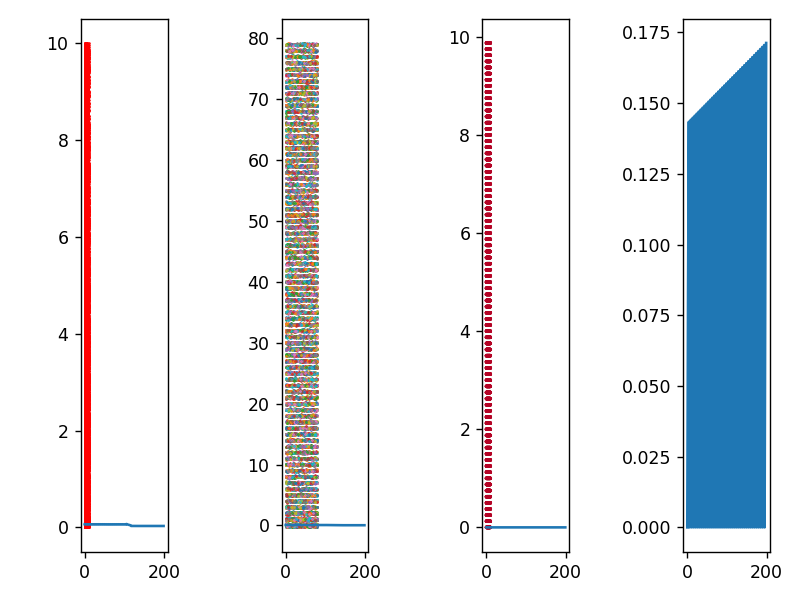

In [21]:
fig, ax = plt.subplots(ncols=4)
ax[0].plot(losses[0:])#vae.history.history["loss"])
ax[1].plot(rec_losses[0:])#vae.history.history["reconstruction_loss"])
ax[2].plot(kl_losses[0:])#vae.history.history["kl_loss"])
ax[3].plot(l_values[0:])
fig.tight_layout()

In [11]:
test_set=[]
for j in range(batch_len, batch_len*2):
    if j>len(xyz):
        break
    test_set.append([scan(xyz[j],8,8, dim=2)])

dataset = tf.data.Dataset.from_tensor_slices((test_set,))

pred = vae.encoder.predict(dataset)

1000/1000 [==============================] - 3s 3ms/step


<IPython.core.display.Javascript object>


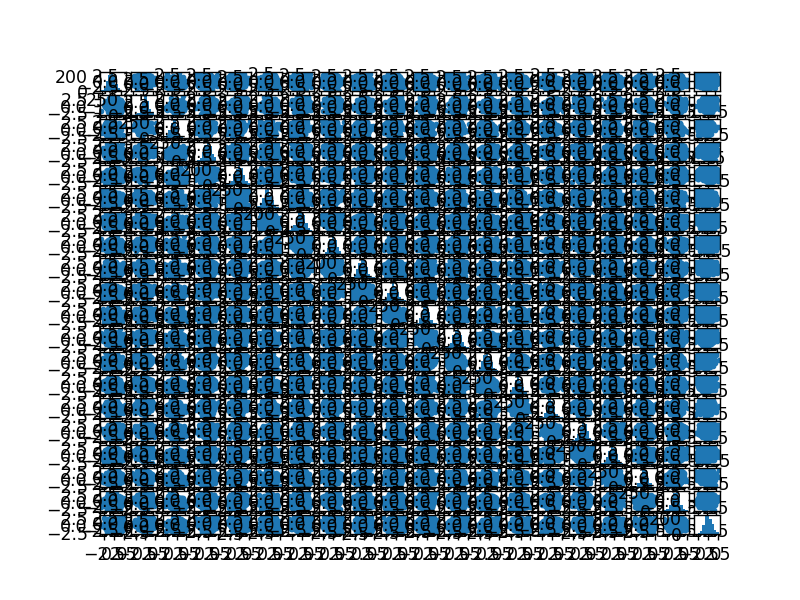

/tmp/ipykernel_3578/368111108.py:8: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.tight_layout()


In [12]:
fig,ax=plt.subplots(ncols=20, nrows=20)
for i in range(20):
    for j in range(20):
        if i!=j:
            ax[i][j].scatter(x=[p[i] for p in pred[2]], y=[p[j] for p in pred[2]], s=5)
        else:
            ax[i][i].hist(x=[p[i] for p in pred[2]])
fig.tight_layout()
#print(len([p[0] for p in pred[2]]), len([p[1] for p in pred[2]]))

ndata=2000
N=25
rdata=np.random.normal(0,2, size=(ndata,5))
rec=decoder.predict(rdata)

In [13]:
rec = decoder.predict(pred[2])

32/32 [==============================] - 1s 27ms/step


In [15]:
N=25
x=[None for i in range(len(rec))]
y=[None for i in range(len(rec))]
for i in range(len(rec)):
    if not (i%10):
        print(i, end="\t", flush=True)
    x[i],y[i]=rand_deploy(rec[i], dim=2, N=N)

0	10	20	30	40	50	60	70	80	90	100	110	120	130	140	150	160	170	180	190	200	210	220	230	240	250	260	270	280	290	300	310	320	330	340	350	360	370	380	390	400	410	420	430	440	450	460	470	480	490	500	510	520	530	540	550	560	570	580	590	600	610	620	630	640	650	660	670	680	690	700	710	720	730	740	750	760	770	780	790	800	810	820	830	840	850	860	870	880	890	900	910	920	930	940	950	960	970	980	990	

In [16]:
#print([(len(x[i]),len(y[i])) for i in range(ndata)])

In [17]:
rec.std()

0.0032181218

<IPython.core.display.Javascript object>


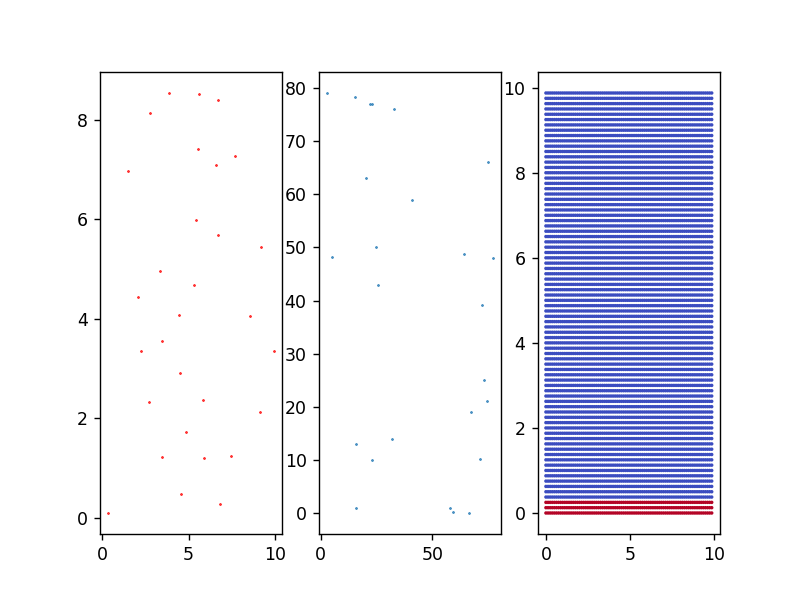

In [43]:
#fig = plt.figure()
#ax = fig.add_subplot(projection='3d')
n_display = 1 #len(rec)
fig, ax=plt.subplots(ncols=3)

In [44]:
for i in range(n_display):
    ax[1].scatter(np.random.normal(0,0.1, size=(N,))+y[i],np.random.normal(0,0.1, size=(N,))+x[i], marker=".", s=1)

In [45]:
xplot=[]
yplot=[]
cols=[]
for i in range(len(rec[0])): #80
    xplot.append([])
    yplot.append([])
    cols.append([])
    for j in range(len(rec[0][i])): #80
        xplot[i].append(j/8)
        yplot[i].append(i/8)
        cols[i].append(0)
        for k in range(n_display):
            cols[i][j] += rec[k][i][j]
        #cols[i][j] *= 30
    
xplot=np.array(xplot).flatten()
yplot=np.array(yplot).flatten()
cols=np.array(cols).flatten()
cols=255*(cols-min(cols))/(max(cols)-min(cols))
rgb = mpl.colormaps["coolwarm"](cols)

ax[2].scatter(yplot, xplot, s=1, c=rgb)

for j in range(n_display):
    ax[0].scatter([i[0] for i in xyz[j]],[i[1] for i in xyz[j]] , color="red", marker=".", s=1)